# <center> 🧠 А нейронки будут? </center>

<img src="https://i.imgflip.com/1sdrv7.jpg" width="400" alt="NN_memes" align='right'/>
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">🛠 Реализация MLP из scikit-learn  </a></li>

<li><a href="#c2">🐍🔥 Самописный MLP на pytorch с двумя головами.</a></li>
<li><a href="#с3">🕸 TabNet </a>
<li><a href="#c4">🧠 Мысли и выводы</a>
<li><a href="#c5">🧸 Дополнительные материалы</a>

</li></ul></font></p>

<div class="alert alert-info">
   
* Когда из бустингов и других алгоритмов выжато всё что можно, и даже блендинг не помогает - можно бросить в бой нейронную сеть!
* NN может поднять скор сама по себе, докинуть при блендинге или обогатить датасет новыми фичами в виде эмбеддингов. <br>
* Главная проблема при использовании нейронки, это не переборщить с её размером - она может запомнить все данные и легко переобучиться. <br>
    
В этом уроке рассмотрим основные подходы для решения задачи с помощью нейронной сети.

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Загружаем train-датасет который мы сохранили на шаге quickstart
rides_info = pd.read_csv('../data/quickstart_train.csv')
rides_info.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.1,172.793237,-5.029476,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.1,203.462289,-14.260456,174,171


In [3]:
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

In [4]:
# закодируем категориальные фичи в one hot encoding вектора
rides_info = pd.get_dummies(rides_info, columns=cat_cols)

In [5]:
# заполним пропущенные значения медианным значением по столбцу
rides_info.fillna(rides_info.median(), inplace=True)

/tmp/ipykernel_241536/2067634496.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rides_info.fillna(rides_info.median(), inplace=True)


## <center>🛠 Готовая реализация нейронной сети MLP из `sklearn`.</center>
Для начала рассмотрим самый простой подход - взять готовую реализацию MLP (multi layer perceptron) из `scikit-learn`.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [7]:
# переведем строковые значения категориального таргета в целочисленные
le = LabelEncoder()
rides_info['target_class'] = le.fit_transform(rides_info['target_class'])

In [8]:
# числовые переменные, которые подвергнем трансформации
num_cols = [col for col in list(rides_info.columns)
            if col not in drop_cols]

<div class="alert alert-info">

Перед подачей в нейросеть, данные необходимо ОБЯЗАТЕЛЬНО нормализовать. <br>
* Cамый простой способ - взять какой-нибудь скейлер из `sklearn`.
* Так же можно поискать SOTA скейлеры для нейронок разного типа в Интернете. Например, [Gauss rank scaler](https://github.com/aldente0630/gauss-rank-scaler).
* Или написать свой

In [94]:
# для нормализации данных используем robust scaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df = scaler.fit_transform(rides_info[num_cols])
df = pd.DataFrame(df, columns=num_cols)

target_scaler = RobustScaler()
target = target_scaler.fit_transform(rides_info['target_reg'].values.reshape(-1, 1))

df['target_reg'] = target
df['target_class'] = rides_info['target_class']

In [87]:
# Проведем эксперимент без нормализации данных
X = rides_info.drop(drop_cols, axis=1)
y = rides_info['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
X = df.drop(['target_class','target_reg'], axis=1)
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Классификация**

In [96]:
clf = MLPClassifier(random_state=42, max_iter=20, verbose=5).fit(X_train, y_train)

Iteration 1, loss = 2.16891360
Iteration 2, loss = 2.06997601
Iteration 3, loss = 1.98756890
Iteration 4, loss = 1.91333799
Iteration 5, loss = 1.84459997
Iteration 6, loss = 1.77749716
Iteration 7, loss = 1.71341305
Iteration 8, loss = 1.64966392
Iteration 9, loss = 1.58735378
Iteration 10, loss = 1.52739432
Iteration 11, loss = 1.46963852
Iteration 12, loss = 1.41371104
Iteration 13, loss = 1.36085464
Iteration 14, loss = 1.31114046
Iteration 15, loss = 1.26409271
Iteration 16, loss = 1.22127515
Iteration 17, loss = 1.18107583
Iteration 18, loss = 1.14461299
Iteration 19, loss = 1.11049582
Iteration 20, loss = 1.07955570


/home/jovyan/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



In [97]:
preds = clf.predict(X_test)

In [98]:
preds[:5]

array([4, 6, 6, 6, 2])

In [99]:
f1_score(y_test, preds, average='macro')

0.5425973554929262

In [100]:
accuracy_score(y_test, preds)

0.5726495726495726

## **Регрессия**

In [106]:
y = df['target_reg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
regr = MLPRegressor(random_state=42, max_iter=50).fit(X_train, y_train)

/home/jovyan/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.



<div class="alert alert-info">

***Важно***: После предикта не забывать делать `inverse_transform`, а то получим предикты и ошибку в другой шкале!

In [108]:
preds = regr.predict(X_test)
preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))
preds[:5]

array([[72.71671533],
       [32.84617531],
       [53.26113851],
       [49.94877966],
       [35.87741341]])

In [109]:
mean_squared_error(y_test, preds) ** 0.5

45.938741736955315

<div class="alert alert-info">

Минусы реализации MLP из `sklearn`:
* Мало возможностей для кастомизации
* Плохо работает с дефолтными параметрами
* Неудобно доставать эмбеддинги
    
Посмотрим на другие подходы!

## <center>🐍🔥 Двух головая нейронка на `PyTorch`.</center>
<div class="alert alert-info">

А как вам идея - решить обе задачи одной моделью? Попробуем сделать это с помощью самописного MLP с двумя головами на фрэймворке `PyTorch`.

In [20]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import copy

In [22]:
# для наших данных и размера нейросети подойдет запуск на cpu
device = torch.device('cpu')

In [23]:
# ВАЖНО! - фиксируем воспроизводимость
def seed_everything(seed=42):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [24]:
# можно попробовать поэкспериментировать с параметрами
class CFG:
    hidden_size=128
    dropout=0.1
    lr=1e-3
    batch_size=128
    num_workers=4
    epochs=20
    num_features=train.shape[1]-2 # кол-во фичей подаваемое на вход
    num_tar_class=train.target_class.nunique() # количество выходов равно кол-ву предсказываемых классов

In [25]:
# датасет выдает фичи и значения целевых переменных
class Rides(Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx,:]
        
        data = row.drop(labels=['target_reg', 'target_class'])
        
        data = torch.FloatTensor(data.values.astype('float'))
        tar_reg = torch.tensor(row['target_reg']).float()
        tar_class = row['target_class'].astype('int')
        
        return data, tar_reg, tar_class

In [26]:
# проверим корректность работы методов нашего класса
next(iter(Rides(train)))

(tensor([-0.7302, -1.5000, -1.4019,  1.0000,  0.2215, -0.1615, -0.1000,  0.4241,
         -0.2246,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]),
 tensor(-0.6091),
 2)

In [27]:
train_datasets = {'train': Rides(train),
                  'val': Rides(test)}

In [28]:
dataloaders_dict = {x: torch.utils.data.DataLoader(train_datasets[x], 
                                                   batch_size=CFG.batch_size, 
                                                   shuffle=True, 
                                                   num_workers=CFG.num_workers)
                    for x in ['train', 'val']}

In [29]:
# Построим архитектуру mlp с двумя головами для регрессии и классифкации

class TabularNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.mlp = nn.Sequential(
                          nn.Linear(cfg.num_features, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size),
                          #nn.BatchNorm1d(cfg.hidden_size),
                          nn.Dropout(cfg.dropout),
                          nn.ReLU(),
                          nn.Linear(cfg.hidden_size, cfg.hidden_size//2),
                          )
        
        self.regressor = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_size // 2, cfg.num_tar_class)
        )

    def forward(self, data):
        x = self.mlp(data)
        tar_reg = self.regressor(x)
        tar_class = self.classifier(x)
        return tar_reg.view(-1), tar_class

In [30]:
model = TabularNN(CFG).to(device)

In [31]:
# оптимайзер и лоссы для регрессии и классификации
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
regression_criterion = nn.MSELoss().to(device)
classification_criterion = nn.CrossEntropyLoss().to(device)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max = epochs * len(dataloaders_dict['train']))

In [32]:
# функция для тренировки, на выходе - обученная модель
def train_model(model, dataloaders, regression_criterion,
                classification_criterion, optimizer, num_epochs=25,
                early_stopping_rounds=5, verbose=2):

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    early_steps = 0
    stop = False

    for epoch in range(num_epochs):
        if stop:
            break
        if epoch % verbose == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels_1, labels_2 in dataloaders[phase]:
                inputs = inputs.to(device)
                labels_1 = labels_1.to(device)
                labels_2 = labels_2.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs_1, outputs_2 = model(inputs)
                    loss_1 = regression_criterion(outputs_1, labels_1)
                    loss_2 = classification_criterion(outputs_2, labels_2)

                    loss = loss_1 + loss_2

                    _, preds_2 = torch.max(outputs_2, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                val_acc_history.append(running_loss)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if epoch % verbose == 0:
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss
                early_steps = 0
            if phase == 'val' and epoch_loss > best_loss:
                early_steps += 1
                if early_steps > early_stopping_rounds:
                    stop = True
                    print(f'Stopped by early_stopping. Epoch: {epoch}')
                    break
               


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
model_ft = train_model(model, dataloaders_dict, regression_criterion,
                classification_criterion, optimizer, num_epochs=22)

Epoch 0/21
----------
train Loss: 2.7229
val Loss: 2.6967
Epoch 2/21
----------
train Loss: 2.1457
val Loss: 1.9737
Epoch 4/21
----------
train Loss: 1.4847
val Loss: 1.4532
Epoch 6/21
----------
train Loss: 1.2597
val Loss: 1.2781
Epoch 8/21
----------
train Loss: 1.1154
val Loss: 1.1958
Epoch 10/21
----------
train Loss: 1.0738
val Loss: 1.1966
Epoch 12/21
----------
train Loss: 1.0457
val Loss: 1.1807
Epoch 14/21
----------
train Loss: 1.0052
val Loss: 1.1928
Epoch 16/21
----------
train Loss: 1.0037
val Loss: 1.1576
Epoch 18/21
----------
train Loss: 0.9600
val Loss: 1.1586
Epoch 20/21
----------
train Loss: 0.9492
val Loss: 1.1499


In [34]:
# p1, p2 - предсказания; l1, l2  - истинные значения

p1, p2, l1, l2 = [], [], [], []

with torch.set_grad_enabled(False):
    # Get model outputs and calculate loss
    for inputs, labels_1, labels_2 in dataloaders_dict['val']:
        inputs = inputs.to(device)
        labels_1 = labels_1.to(device)
        labels_2 = labels_2.to(device)
        l1.extend(labels_1.detach().cpu().numpy())
        l2.extend(labels_2.detach().cpu().numpy())
        
        outputs_1, outputs_2 = model_ft(inputs)
        _, outputs_2 = torch.max(outputs_2, 1)

        p1.extend(outputs_1.detach().cpu().numpy())
        p2.extend(outputs_2.detach().cpu().numpy())

In [35]:
# Сохраняем веса модели
torch.save(model_ft.state_dict(), 'tab_model.pth')

**посмотрим на результаты по каждой из задач**

In [36]:
# классификация
from sklearn.metrics import f1_score
f1_score(l2, p2, average='macro'), accuracy_score(l2, p2)

(0.6758970784583773, 0.6794871794871795)

In [37]:
p1 = target_scaler.inverse_transform(np.array(p2).reshape(-1, 1))
l1 = target_scaler.inverse_transform(np.array(l2).reshape(-1, 1))

In [38]:
# регрессия
mean_squared_error(l1, p1) ** 0.5

35.16737452198032


## Чтобы улучшить скор можно поэкспериментировать с:

<div class="alert alert-info">

- нормализацией данных, заполнением пропусков 
- архитектурой сети
    * добавить линейных слоев, изменить `hidden_size`
    * добавить/изменить `Dropout`, `BatchNorm` слои
    * изменить функцию активации (`LeakyReLU` и пр.)
- попробовать другие оптимизаторы ( `AdamW`, `RAdam`, `SGD` и пр.)
- попробовать разные lr sheduler (`LambdaLR`, `StepLR`, `CyclicLR` и пр.)

<div class="alert alert-info">

Плюсы использования самописных нейросетей:
* можно решать одной сеткой несколько задач
* кастомизация без ограничений
* любые лоссы и метрики из `PyTorch` или самописные
* легко достать эмбеддинги для обучения бустингов ([пример](https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/9.2%20-%20Embeddings.ipynb))

# <center>🕸 `TabNet` - "SOTA" для табличек.</center>
А теперь решим задачу с помощью [TABNET](https://github.com/dreamquark-ai/tabnet).

<div class="alert alert-info">

[Статья на arxiv.org](https://arxiv.org/abs/1908.07442) <br>
[Подробное описание архитектуры на русском языке.](https://habr.com/ru/articles/540736/)
    
`TabNet` - фреймворк предоставляющий готовые реализации нейронных сетей для задач с табличными данными, реализованный на `PyTorch`, с удобным `sklearn`-подобным интерфейсом. <br>
Взаимодействие с фрэймворком очень похоже на библиотеки бустингов: 
* методы `fit`, `predict`
* встроенный feature importance
* встроенная визуализация
* может принимать категориальные признаки на вход

In [3]:
!pip install pytorch-tabnet -q

ERROR: torchvision 0.15.1+cu117 has requirement torch==2.0.0, but you'll have torch 1.13.1 which is incompatible.


## **Классификация**

In [40]:
y = df['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

clf = TabNetClassifier(device_name='cpu')
clf.fit(X_train.values,
        y_train,
        patience=100,
        eval_set=[(X_test.values, y_test)])

### Посмотрим `feature importance`

In [42]:
for i, j in sorted(zip(clf.feature_importances_.astype('float16'), X_train.columns), reverse=True):
    print(i, j)

0.446 mean_rating
0.2507 speed_max
0.1582 rating_min
0.0699 model_Hyundai Solaris
0.03772 model_Smart Coupe
0.01518 fuel_type_petrol
0.006153 model_Audi A3
0.002333 riders
0.00207 car_type_standart
0.001887 model_VW Tiguan
0.001779 distance_sum
0.001025 model_Nissan Qashqai
0.0009217 model_Volkswagen ID.4 
0.0008307 model_Skoda Rapid
0.0008187 year_to_work
0.0007353 model_Renault Kaptur
0.000645 model_Smart ForFour
0.0005226 model_Kia Rio
0.00048 model_VW Polo
0.000322 car_type_business
0.0003161 model_Mini Cooper
0.000274 model_Fiat 500
0.0002148 model_Mercedes-Benz GLC
0.000178 user_ride_quality_median
0.0001267 model_Audi A4
0.00010693 year_to_start
0.00010663 model_Kia Rio X-line
7.35e-05 model_Smart ForTwo
3.755e-05 car_type_economy
3.56e-05 model_Tesla Model 3
2.72e-05 car_type_premium
1.86e-05 car_rating
1.26e-05 model_Kia Sportage
1.097e-05 model_Mercedes-Benz E200
7.2e-06 model_BMW 320i
1.3e-06 user_uniq
9e-07 fuel_type_electro
0.0 model_VW Polo VI
0.0 model_Renault Sandero
0.

## Интерпретация
[Пример интерпретации TabNet](https://www.kaggle.com/code/carlmcbrideellis/tabnet-and-interpretability-jane-street-example)

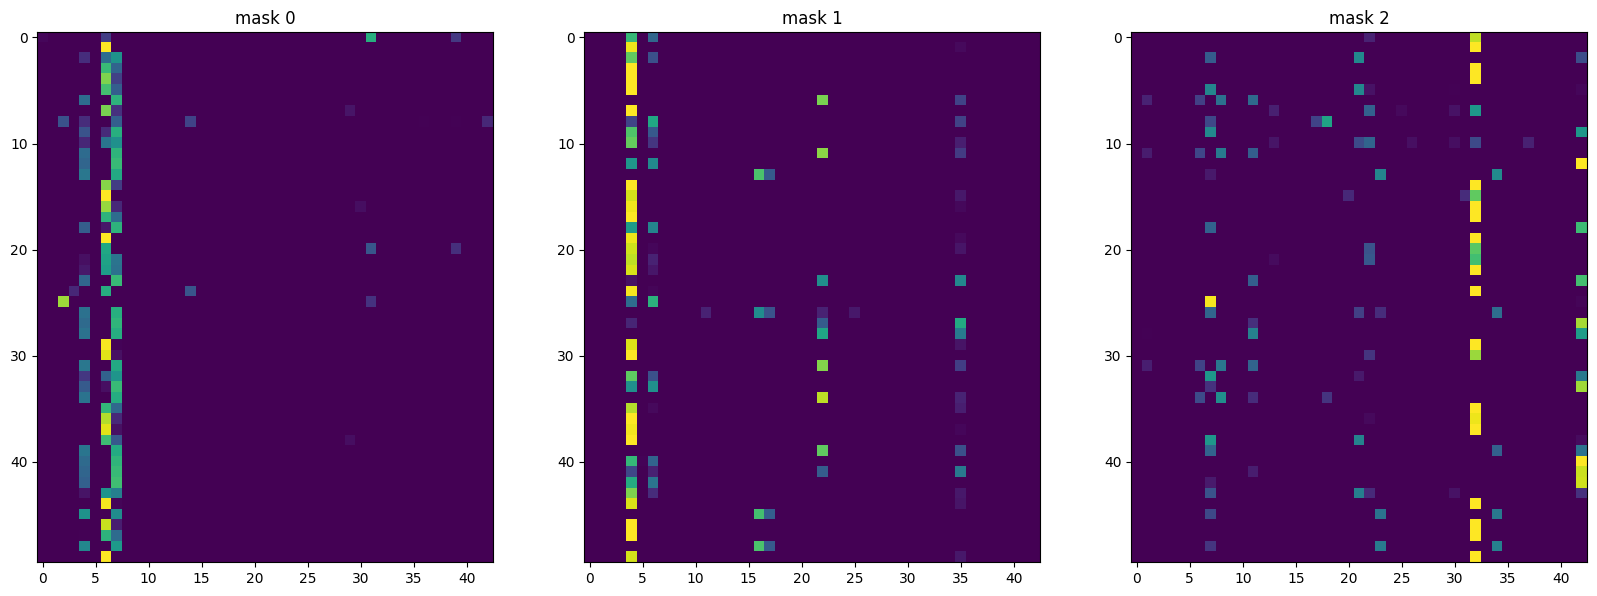

In [43]:
import matplotlib.pyplot as plt

explain_matrix, masks = clf.explain(X_test.values)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [58]:
normalized_explain_mat = np.divide(explain_matrix, explain_matrix.sum(axis=1).reshape(-1, 1)+1e-8)

# Add prediction to better understand correlation between features and predictions
preds = clf.predict(X_test.values)

explain_and_preds = np.hstack([normalized_explain_mat, preds.reshape(-1, 1)])

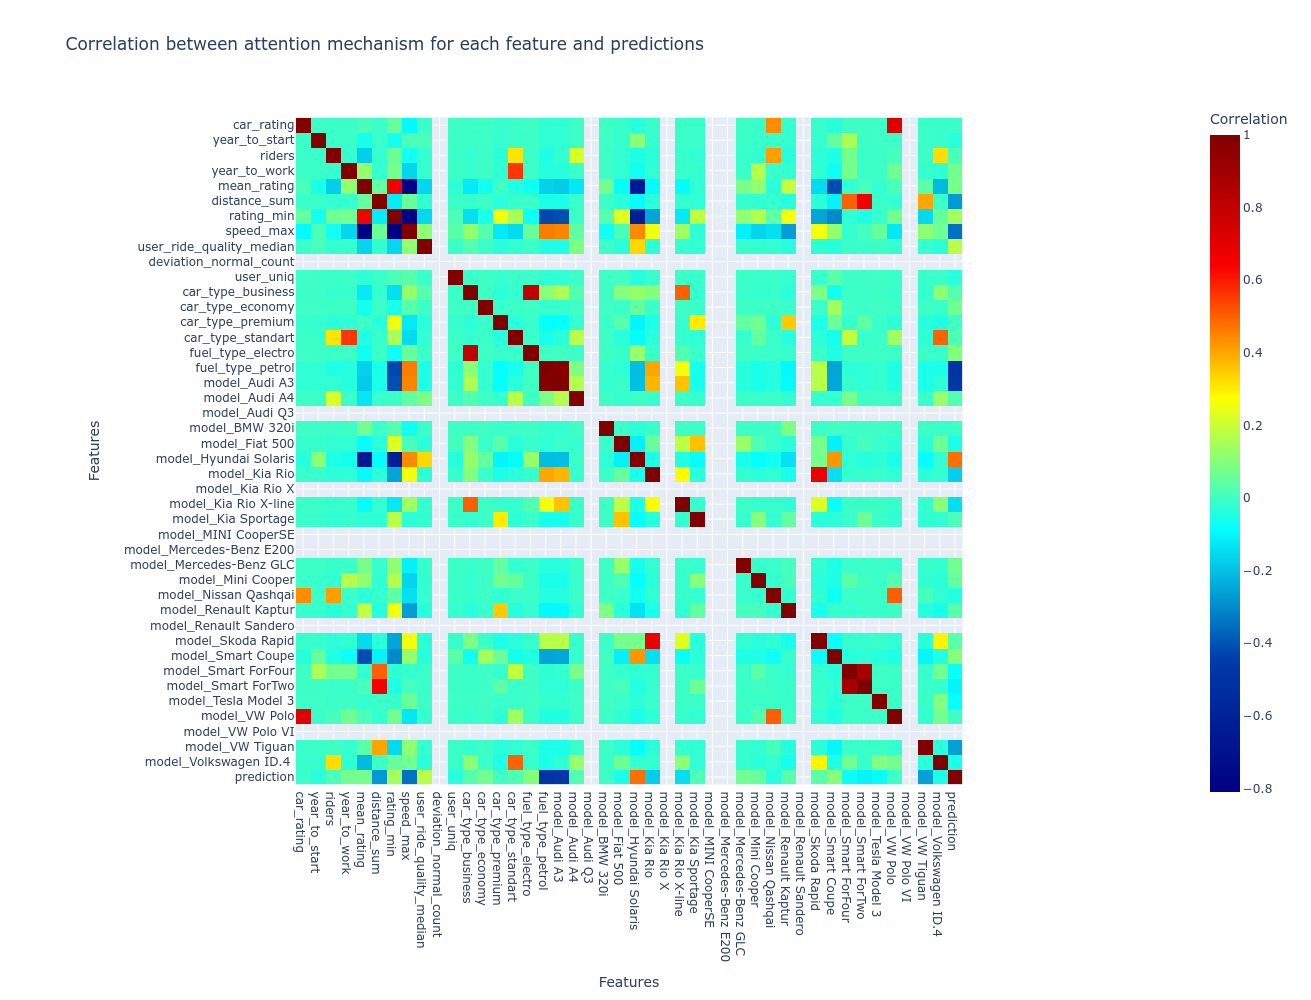

In [68]:
correlation_importance = np.corrcoef(explain_and_preds.T)
px.imshow(correlation_importance,
          labels=dict(x="Features", y="Features", color="Correlation"),
          x=list(X_test.columns)+["prediction"], y=list(X_test.columns)+["prediction"],
          title="Correlation between attention mechanism for each feature and predictions",
          width=1000,
          height=1000,
          color_continuous_scale='Jet')

### Инференс

In [44]:
preds = clf.predict(X_test.values)

In [45]:
preds[:5]

array([4, 6, 3, 6, 6])

In [47]:
f1_score(y_test, preds, average='macro'), accuracy_score(y_test, preds)

(0.5642267504275466, 0.6047008547008547)

## **Регрессия**

In [48]:
y = df['target_reg']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
reg = TabNetRegressor(device_name='cpu')
reg.fit(
  X_train.values, y_train.values.reshape(-1,1),
  eval_set=[(X_test.values, y_test.values.reshape(-1,1))]
)

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning:

Device used : cpu



epoch 0  | loss: 1.76506 | val_0_mse: 0.7045  |  0:00:00s
epoch 1  | loss: 1.2924  | val_0_mse: 0.68811 |  0:00:00s
epoch 2  | loss: 1.10533 | val_0_mse: 0.67619 |  0:00:00s
epoch 3  | loss: 0.94004 | val_0_mse: 0.67994 |  0:00:00s
epoch 4  | loss: 0.89023 | val_0_mse: 0.67594 |  0:00:00s
epoch 5  | loss: 0.80719 | val_0_mse: 0.67334 |  0:00:00s
epoch 6  | loss: 0.73245 | val_0_mse: 0.66269 |  0:00:00s
epoch 7  | loss: 0.75244 | val_0_mse: 0.65668 |  0:00:00s
epoch 8  | loss: 0.65909 | val_0_mse: 0.67951 |  0:00:00s
epoch 9  | loss: 0.62468 | val_0_mse: 1.07484 |  0:00:00s
epoch 10 | loss: 0.57264 | val_0_mse: 1.53159 |  0:00:00s
epoch 11 | loss: 0.58079 | val_0_mse: 1.77093 |  0:00:00s
epoch 12 | loss: 0.6089  | val_0_mse: 1.82843 |  0:00:00s
epoch 13 | loss: 0.64123 | val_0_mse: 1.9527  |  0:00:00s
epoch 14 | loss: 0.62013 | val_0_mse: 1.80956 |  0:00:01s
epoch 15 | loss: 0.59087 | val_0_mse: 1.843   |  0:00:01s
epoch 16 | loss: 0.57148 | val_0_mse: 1.88329 |  0:00:01s
epoch 17 | los

/opt/conda/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!



In [51]:
preds = reg.predict(X_test.values)
preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))
preds[:5]

array([[41.067886],
       [41.123016],
       [40.908028],
       [40.900574],
       [41.344833]], dtype=float32)

In [52]:
mean_squared_error(y_test, preds) ** 0.5

40.50636571221867

<div class="alert alert-info">

Посмотрим на итоговую таблицу точности по всем моделям - пока точность не впечатляет. <br>
Но для примера использованы дефолтные гиперпараметры и малое число эпох. Немного потюнив гиперпараметры можно легко выбить точность более 0.7 для классификации даже из `sklearn - модели` и значительно снизить RMSE для регрессии. Попробуйте сделать это сами!

<center> <img src='../images/nn1.png'> </center>

## <center>🧠 Мысли и выводы</center>


<div class="alert alert-info">

* Нейронные сети могут использоваться как самостоятельные модели для решения задач на табличных данных, так и разнообразить ансамбль.
* Обязательно делать нормализацию, и не забывать об обратном преобразовании для предсказаний.
* Рабочий кейс: сначала попробовать готовое, что быстро заводится - посмотреть дает нейросеть адекватный результат для конкретной задачи или нет. Потом уже пробовать запускать что-то смописное, кастомное.
    
В следующих уроках рассмотрим более продвинутые инструменты для создания пайплайнов обучения нейросетей и получние эмбеддингов из них.

## <center>🧸 Дополнительные материалы</center>

* [Pytorch-lifestream](https://dllllb.github.io/pytorch-lifestream/) - библиотека для обработки последовательных данных (банковские транзакции, кликстрим и.т.п.)
* [Pytorch для табличек](https://pytorch-tabular.readthedocs.io/en/stable/tabular_model/)